## 진행 계획
1. 데이터 확인 및 전처리
2. 모델 선정 및 학습
3. 모델 성능 및 속도 확인

### 1. 데이터 확인

In [ ]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from tqdm import tqdm
from pathlib import Path

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
'''
처음 Train_Set.zip을 압축해제 하기 위한 폴더 생성과 명령어이므로 처음 실행 시 사용 
'''
Path("/gdrive/MyDrive/임시/data/Train").mkdir(parents=True, exist_ok=True) # 상위 Path가 없으면 새로 생성, 폴더가 이미 있는 경우에는 무시
!unzip -uq "/gdrive/MyDrive/임시/data/Train_Set.zip" -d "/gdrive/MyDrive/임시/data/Train" # 위에서 생성한 폴더에 Train 데이터가 있는 zip파일의 압축을 해제 (-u : 파일을 덮어쓰지 않고 대체, -q : 압축 해제 중 상세정보 미출력, -d : 지정 디렉토리에 압축 해제)

In [ ]:
# Train 데이터셋 개수 확인
files = list(glob.glob('/gdrive/MyDrive/임시/data/Train/*.xml')) # Train 데이터의 압축을 해제한 폴더에서 확장자가 xml인 파일을 불러와서 리스트로 변환
len(files) # 리스트에 xml파일이 몇개나 있는지 확인 (= 33245개의 유저별 주행 기록 확인)

33245

#### Sample train data 확인

In [ ]:
# Train 데이터 샘플 확인
df_sample = pd.read_xml(files[0]) # xml파일 중 하나를 DataFrame으로 변환

In [ ]:
df_sample.head()

In [ ]:
df_sample.info() # 컬럼별 타입과 Null 값 확인

In [ ]:
df_sample.describe() # 샘플 데이터프레임의 데이터 요약 확인(Outlier 확인)

In [ ]:
df_sample.corr() # 피쳐별 관계 확인

In [ ]:
df_sample['b'].value_counts()

0    773
1    301
4     33
5     15
3     12
Name: boost, dtype: int64

In [ ]:
df_sample[df_sample['b']==4].head(10) 

In [ ]:
df_sample.tail(15) 

In [ ]:
print(ET.parse(files[0]).getroot().attrib['rT']) # xml 파일에 있는 Label 데이터를 가져오기 위해 사용

113.3


샘플데이터를 통해 알게된 점
1. 데이터의 타입은 모두 숫자(float, int)로 구성되어있다.
2. feature별 상관관계

#### 전체 Train data 병합 및 저장

In [ ]:
'''
Train Data의 병합 시 시간이 오래걸리기 때문에 시간이나 메모리를 아낄 수 있는 방법이 있는지 검색 후 2가지 방법을 시도
1. xml로 만든 데이터프레임을 for문을 통해 하나씩 concat
2. xml로 만든 데이터프레임을 for문을 통해 list에 append를 통해 모아 한번에 concat
2번 방법이 메모리를 효율적으로 아낄 수 있다고 해 테스트 해봤으나 코랩의 상태에 따라 실행시간이 달라져 정확한 비교는 힘들었으나 체감되는 시간은 비슷했음
'''
max = 0
# xml을 하나씩 읽어 concat하는 것보다 list를 통해 df를 입력받은 뒤 한번에 concat을 하는 것이 속도가 빠르고 메모리를 아낄 수 있기 때문에 아래와 같이 코드를 작성
list_of_df = []

for file in tqdm(files): 
    temp = pd.read_xml(file)

df = pd.concat(list_of_df)

row_length = [len(df) for df in list_of_df] # xml 별 최대 행 길이 확인(최대 주행기록)
print(max(row_length))

In [ ]:
df = pd.read_csv("/gdrive/MyDrive/임시/data/total_data.csv")
df.head()

In [ ]:
'''
하나의 xml을 데이터프레임으로 변경했을 때와 다르게 info()를 실행해도 Null Count가 되지 않았아 isnull()과 sum()을 통해 결측치 확인
'''
print(df.info()) # 모든 유저 데이터가 모인 DataFrame에서 null값 확인 (=39,500,589 row)
print()
print(df.isnull().sum())

In [ ]:
'''
데이터 병합 작업의 시간이 오래 걸리기 때문에 합쳐진 데이터프레임을 csv로 저장 
'''
df.to_csv("/gdrive/MyDrive/임시/data/total_data.csv", encoding="utf-8-sig", header=True, index=False) #index는 저장하지 않고 header(컬럼)은 저장

#### 데이터 가설 확인

In [ ]:
b_check = df[df['b']==4] 
print(b_check[['x', 'y']].value_counts()) 
print()
print(b_check[['x']].value_counts()) 

### 1-2 데이터 전처리

In [ ]:
def head_df_extractor(df):
    head_df = df.head(1).iloc[0,1:3]                                            # 데이터프레임 첫 행의 Series
    x, y = head_df['x'], head_df['y']                                     # Series의 x, y를 저장
    index = df[(df['x'] != df['x'].shift()) | (df['y'] != df['y'].shift())].iloc[1].name
    df = df[index:]
    df.reset_index(drop=True, inplace=True)                                     # 데이터를 잘라내며 어긋난 인덱스가 생기기 때문에 인덱스를 초기화
    return df

In [ ]:
def tail_df_extractor(df):
    tail_df = df.tail(1).iloc[0,1:3]
    tail_x, tail_y = tail_df['x'], tail_df['y']
    tail_index = df[(df['x'] != df['x'].shift()) | (df['y'] != df['y'].shift())].iloc[-1].name
    df = df[:tail_index]
    df.reset_index(drop=True, inplace=True)
    return df

In [ ]:
def random_sample_extractor(df, random_seed):                                   
    label = df.iloc[-1]['t']                                                 # 샘플 추출 전 label 추출
    df_sample = df.copy(deep=True)                                              # 데이터프레임 복사 시 원본에 영향이 가지 않도록 딥 카피
    df_sample = df_sample[:-300]                                                # 데이터프레임 행의 끝부분 300개를 잘라낸 샘플
    extract_index = list(df_sample.sample(random_state=random_seed).index)[0]   # 샘플 데이터 프레임의 index를 추출 
    df = df.iloc[extract_index:extract_index+300]                               # 샘플 인덱스를 기준으로 300개 행 추출
    return df, label

In [ ]:
random_seed = 42
list_of_df_x = []
list_of_df_y = []

for idx, file in enumerate(tqdm(files)): 
    temp = pd.read_xml(file)                               # xml to Dataframe
    df = head_df_extractor(temp)                           
    df = tail_df_extractor(df)                             
    df, label = random_sample_extractor(df, random_seed)   
    if (len(df) < 300):                 
        print(f"{idx} 번째에서 데이터 개수가 미달한 데이터가 있습니다. :{len(df)}, 파일 이름 : {file}")
        continue
    elif (df["b"]==4).any():
        print(f"{idx} 번째에서 4번이 확인되어 제외합니다. 파일 이름 : {file}")
        continue
    list_of_df_x.append(df)
    list_of_df_y.append(label)

df_x = pd.concat(list_of_df_x)
df_y = pd.DataFrame(list_of_df_y, columns=['label'])

In [ ]:
"""
최종적으로 만들어진 데이터 셋을 csv로 저장
"""                                                           
df_x.to_csv("/gdrive/MyDrive/임시/data/x.csv", encoding="utf-8-sig", header=True, index=False) # header(컬럼)은 저장, index는 저장하지 않는다.
df_y.to_csv("/gdrive/MyDrive/임시/data/y.csv", encoding="utf-8-sig", header=True, index=False)

### 2. 모델 선정 및 훈련

구해야 할 최종 도착 시간이 30초간의 연속된 주행기록 예측하는 시계열 회귀 예측 문제로 인식하고 시계열 예측 모델 중 가장 접하기 쉬웠던 LSTM과 LSTM에서 조금 더 가볍게 만들어진 GRU 2가지를 모델로 선정하고 LSTM과 GRU의 성능이나 시간이 어느정도 차이가 있을지 테스트 해보기로 했다.

#### LSTM (Long-Short Term Memory) 
장/단기 기억을 가능하게 만들어진 신경망 구조로 RNN이 이전 단계에서 얻은 정보를 지속하며 학습할 수 있도록 만들어졌지만 학습이 계속될수록 기울기 소실이나 기울기 폭발이 생길 수 있어 학습이 되지 않는 문제점을 가지고 있었는데 이 문제를 해결하기 위해 게이트를 통해 이전 상태를 조절하는 기능을 만들어 RNN의 단점을 해결한 모델이다.

<center><img src ="https://drive.google.com/uc?id=13f5sWceNCWoZne6wlM6tPno7O-cJODew" height=300 width=500></center>
사진 출처 : <a href="https://velog.io/@yuns_u/LSTMLong-Short-Term-Memory%EA%B3%BC-GRUgated-Recurrent-Unit">링크</a>

* Forget Gate
> Hidden state와 X를 Sigmoid를 통해 Cell State에 영향 여부를 결정한다. (0 - 소실, 1- 유지)
* Input Gate
> Hidden State와 X를 Sigmoid를 이용해 업데이트 값을 결정하고 Tanh를 이용해 새로운 벡터로 바꿔 Cell state에 더해준다. 
(Sigmoid를 통과하며 0이된 값들은 Tanh를 통과한 값에 곱해지며 
업데이트가 되지 않는다.(어떤 수에 0을 곱해도 0이기 때문)
* Cell State
> 상태값을 보존하고 있는 layer로 게이트의 값에 따라 정보를 유지하고 버릴 것인지 정해지며 이런 정보를 바탕으로 출력에도 영향을 끼치게 된다.
* Output Gate
> Cell State의 값을 Tanh를 이용해 -1과 1사이의 출력을 생성하고 Sigmoid를 통해 나온 0과 1중 하나의 값을 다음 신경망의 Hidden State와 출력으로 내보낸다.

#### GRU (Gate Recurrent Unit)
LSTM의 간소화된 버전으로 Cell State를 없앴으며

LSTM에 비해 파라미터가 적어 훈련 시간 절약 되는 장점이 있다.

성능적으로는 Task별로 차이가 있어 LSTM과 GRU 어떤 것이 좋다고는 할 수 없다.

<center><img src ="https://drive.google.com/uc?id=1RazpVgrWFiCUyhoj2vlA0iby1ebmIYYf" height=300 width=500></center>
사진 출처 : <a href="https://blog.naver.com/PostView.naver?blogId=sooftware&logNo=221783612034&redirect=Dlog&widgetTypeCall=true&directAccess=false">링크</a>


#### 모델 세팅 및 훈련

데이터셋을 train, valid로 분리

In [ ]:
x = pd.read_csv("/gdrive/MyDrive/임시/data/x.csv")                              
y = pd.read_csv("/gdrive/MyDrive/임시/data/y.csv")

print(x.shape) 
print(y.shape)

(9972600, 5)
(33242, 1)


In [ ]:
x.drop("t", axis=1, inplace=True) # x에서 t 컬럼 삭제
print(x.shape)
print(y.shape)

(9972600, 4)
(33242, 1)


In [ ]:
"""
batch_size 33242를 8:2로 나누었을 때 0으로 떨어지지 않아 33240개로 조정 x,y의 샘플을 각각 600개, 2개씩을 제외해 남는 데이터가 없도록 만든다.
"""
x = x.iloc[:-600]
y = y.iloc[:-2]
print(x.shape)
print(y.shape)

(9972000, 4)
(33240, 1)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
numeric_features = ["x", "y"] # 연속형 변수 정의
numeric_transformer = MinMaxScaler() # 연속형 변수 스케일러 정의

categorical_features = ["b", "d"] # 카테고리형 변수 정의
categorical_transformer = OneHotEncoder(categories='auto') # 카테고리형 변수 스케일러 정의

preprocessor = ColumnTransformer(
    transformers=[ 
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        ])

preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)])

In [ ]:
# 연속형, 카테고리형 데이터 스케일링
preprocessor_pipe.fit(x) # x에 맞춰 변수 정의(이후 변경된 z를 fit할 경우 z를 기준으로 다시 변경되니 주의)
x_train_transformed = preprocessor_pipe.transform(x) # fit된 파이프라인에 맞게 x를 변형

In [ ]:
print(type(x_train_transformed))
print(x_train_transformed.shape)

<class 'numpy.ndarray'>
(9972000, 8)


In [ ]:
# train / validation set 8:2로 분리
train_size = int(len(x_train_transformed) * 0.8) 
label_size = int((train_size / 300))

x_train = x_train_transformed[:train_size]
x_valid = x_train_transformed[train_size:]

y_train = y.iloc[:label_size, :].to_numpy()
y_valid = y.iloc[label_size:, :].to_numpy()

# 스케일된 데이터의 shape 확인
print(f"x_train.shape : {x_train.shape}")
print(f"y_train.shape : {y_train.shape}")
print(f"x_valid.shape : {x_valid.shape}")
print(f"y_valid.shape : {y_valid.shape}")

x_train.shape : (7977600, 8)
y_train.shape : (26592, 1)
x_valid.shape : (1994400, 8)
y_valid.shape : (6648, 1)


In [ ]:
"""
LSTM의 입력은 (batch_size, time_steps, input_dim)로 3차원으로 구성된다.
batch_size - 시퀀스의 개수
time_steps - 시퀀스의 시간 차원
input_dim - 입력될 feature의 수
"""
x_train = x_train.reshape(-1, 300, 8)
x_valid = x_valid.reshape(-1, 300, 8)
print(x_train.shape) # label 데이터와 동일한 shape을 가지는지 확인
print(x_valid.shape)

(26592, 300, 8)
(6648, 300, 8)


#### 1차 학습 시도

In [ ]:
model = Sequential()
model.add(LSTM(10, activation="relu", input_shape=(300,8), recurrent_dropout=0.2))              # 오버피팅을 방지하기 위해 recurrent_dropout을 사용
model.add(Dense(1))                                                                             # 회귀문제이기 때문에 최종적인 값은 1개로 출력

model.compile(loss="mean_squared_error", optimizer='adam')                                      # 손실함수는 Mean-squered-error, Optimizer는 Adam

early_stopping_callback = EarlyStopping(monitor="val_loss", patience=5)                         # 검증 데이터의 정확도가 5번 연속 떨어지는 경우 학습을 멈춘다.
model_checkpoint = ModelCheckpoint(filepath='"/gdrive/MyDrive/임시/data/best_model_weights.h5', # 저장할 경로
                                    monitor='val_loss',                                         # 모니터링 기준
                                    save_best_only=True)                                        # 모니터링 지표가 가장 좋은 성능을 보인 모델 가중치만 저장
callbacks = {"early_stopping":early_stopping_callback, "model_checkpoint":model_checkpoint}

history = model.fit(x_train, y_train, batch_size=64, epochs=30, shuffle=False, validation_data=(x_valid, y_valid), callbacks=callbacks) # 에폭 마다 데이터가 섞이지 않도록 shuffle 옵션을 False로 설정

Epoch 1/30
416/416 [==============================] - 297s 709ms/step - loss: 16172.7920 - val_loss: 15551.3682
Epoch 2/30
416/416 [==============================] - 294s 707ms/step - loss: 13047.8721 - val_loss: 15405.4150
Epoch 3/30
416/416 [==============================] - 292s 701ms/step - loss: 12910.9541 - val_loss: 15256.5186
Epoch 4/30
416/416 [==============================] - 292s 701ms/step - loss: 12770.5850 - val_loss: 15104.5459
Epoch 5/30
416/416 [==============================] - 292s 701ms/step - loss: 12627.9600 - val_loss: 14949.1279
Epoch 6/30
416/416 [==============================] - 292s 702ms/step - loss: 12481.2246 - val_loss: 14789.4658
Epoch 7/30
416/416 [==============================] - 294s 708ms/step - loss: 12329.9062 - val_loss: 14624.3223
Epoch 8/30
416/416 [==============================] - 293s 705ms/step - loss: 12174.0771 - val_loss: 14452.6367
Epoch 9/30
416/416 [==============================] - 292s 703ms/step - loss: 12010.2695 - val_loss: 142

In [ ]:
model.save('/gdrive/MyDrive/임시/data/best_model_weights.h5') # 모델 가중치 저장

LSTM의 유닛을 100인 상태로 시작했을 때 loss가 NaN값으로 나타나 구글링을 통해 처리 방법을 확인한 뒤 4가지의 방법을 찾았고 그 중 LSTM 유닛을 줄이고 dropout을 줄이는 방향으로 다시 학습을 시도해보았다.
1. 학습률을 낮추기
2. 입력 데이터에 NaN 값이 확인
3. Dropout, Batch Normalization 추가 또는 LSTM unit을 줄인다.
4. 가중치 초기화

#### Loss 검증

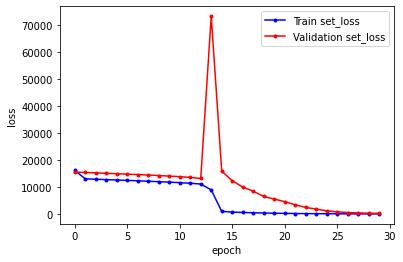

In [ ]:
y_loss = history.history['loss']                                                # 학습 데이터셋 loss
y_valid_loss = history.history['val_loss']                                      # 검증 데이터셋 loss

x_len = np.arange(len(y_loss))                                                  # 0부터 y_loss의 길이만큼 1씩 증가하는 array 생성

plt.plot(x_len, y_loss, marker='.', c='b', label="Train set_loss")              # 학습 데이터셋 loss 표현(파란색)
plt.plot(x_len, y_valid_loss, marker='.', c='r', label="Validation set_loss")   # 검증 데이터셋 loss표현(빨간색)
plt.legend(loc=0)                                                               # lable 위치 지정 (0 = best)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
print(f" RMSE : {np.sqrt(history.history['val_loss'][-1]):.2f}") # 최종 epoch의 validation 데이터셋  

 RMSE : 17.43


#### 완성된 모델 테스트

In [ ]:
model = load_model('/gdrive/MyDrive/임시/data/best_model_weights.h5')

test_df = pd.read_xml("/gdrive/MyDrive/임시/data/Test_sample.xml")
test_df = test_df[:-1]
test_transformed = preprocessor_pipe.transform(test_df) 
test = test_transformed.reshape(-1,300,8)  
preds = model.predict(test)

# 예측값 출력
print('Predicted:', preds) # Real label : 125.4

1/1 [==============================] - 4s 4s/step
Predicted: [[121.51439]]


Test 값을 넣은 결과를 보려고 모델을 불러 scaling을 하고 reshape를 해서 예측을 시도했지만 훈련에서 사용했던 one-hot encoder에 들어간 카테고리의 수가 달라 입력된 8개의 input_dim보다 작은 크기가 나왔고 test할 xml의 길이가 300개가 아닌 301개로 확인되어 테스트 결과를 보지는 못했다.

#### 1차 학습 결과
30 epoch 중 15 epoch 이상부터 과적합이 의심되긴 했으나 val_loss가 epoch가 진행되며 점점 낮아지는 모습을 확인 할 수 있었다.
이후 학습 시에는 모델 성능 향상을 위해 아래와 같은 작업을 후 재학습 할 예정
* LSTM의 유닛 증가(모델의 복잡도 상승)
* recurrent_dropout 0.3으로 증가
* Batch Normalization layer 추가
* epoch 증가

#### 2차 학습 시도

In [ ]:
model = Sequential()
model.add(LSTM(15, activation="relu", input_shape=(300,8), recurrent_dropout=0.3))                # 오버피팅을 방지하기 위해 recurrent_dropout을 사용
model.add(BatchNormalization())                                                                   # 오버피팅을 방지하기 위해 BatchNormalization 추가
model.add(Dense(1))                                                                               # 회귀문제이기 때문에 최종적인 값은 1개로 출력

model.compile(loss="mean_squared_error", optimizer='adam')                                        # 손실함수는 Mean-squered-error, Optimizer는 Adam

early_stopping_callback = EarlyStopping(monitor="val_loss", patience=5)                           # 검증 데이터의 정확도가 5번 연속 떨어지는 경우 학습을 멈춘다.
model_checkpoint = ModelCheckpoint(filepath='"/gdrive/MyDrive/임시/data/best_model_weights_2.h5', # 저장할 경로
                                    monitor='val_loss',                                           # 모니터링 기준
                                    save_best_only=True)                                          # 모니터링 지표가 가장 좋은 성능을 보인 모델 가중치만 저장
callbacks = {"early_stopping":early_stopping_callback, "model_checkpoint":model_checkpoint}

history = model.fit(x_train, y_train, batch_size=64, epochs=30, shuffle=False, validation_data=(x_valid, y_valid), callbacks=callbacks) # 에폭 마다 데이터가 섞이지 않도록 shuffle 옵션을 False로 설정

Epoch 1/30
416/416 [==============================] - 333s 781ms/step - loss: 12808.6289 - val_loss: 14031.3076
Epoch 2/30
416/416 [==============================] - 321s 772ms/step - loss: 9946.6885 - val_loss: 9951.6172
Epoch 3/30
416/416 [==============================] - 319s 767ms/step - loss: 6004.8193 - val_loss: 5592.7148
Epoch 4/30
416/416 [==============================] - 318s 764ms/step - loss: 2693.2642 - val_loss: 2485.1958
Epoch 5/30
416/416 [==============================] - 318s 764ms/step - loss: 846.6618 - val_loss: 965.0357
Epoch 6/30
416/416 [==============================] - 319s 766ms/step - loss: 207.4498 - val_loss: 464.4306
Epoch 7/30
416/416 [==============================] - 318s 764ms/step - loss: 85.1412 - val_loss: 342.8159
Epoch 8/30
416/416 [==============================] - 316s 760ms/step - loss: 72.9827 - val_loss: 318.0674
Epoch 9/30
416/416 [==============================] - 316s 760ms/step - loss: 72.2598 - val_loss: 313.7989
Epoch 10/30
416/416 [

In [ ]:
model.save('/gdrive/MyDrive/임시/data/best_model_weights_check.h5') # 모델 가중치 저장

#### 2차 학습 결과

처음 모델 학습을 시작하자 마자 검증셋 오류가 nan으로 나타나 다시 실행해보니 이번엔 정상적으로 학습이 잘 되었다.
학습 시 초기 값의 문제 같은데 자세한 부분은 검색을 통해 어떤 부분 때문에 재학습 시 다른 결과를 보이게 되는지 확인해봐야 할 것 같다.

모델 체크포인트도 5회 연속 검증셋의 loss가 떨어질 경우로 세팅을 해놨지만 epoch의 횟수가 많지 않아 2회나 3회 정도로 하는게 좋을 것 같다.



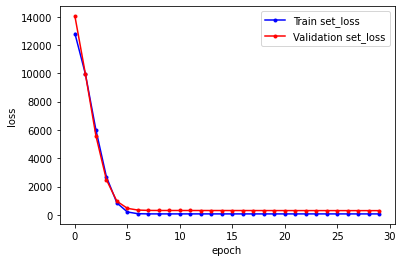

In [ ]:
y_loss = history.history['loss']                                            # 학습 데이터셋 loss
y_valid_loss = history.history['val_loss']                                      # 검증 데이터셋 loss

x_len = np.arange(len(y_loss))                                                  # 0부터 y_loss의 길이만큼 1씩 증가하는 array 생성

plt.plot(x_len, y_loss, marker='.', c='b', label="Train set_loss")              # 학습 데이터셋 loss 표현(파란색)
plt.plot(x_len, y_valid_loss, marker='.', c='r', label="Validation set_loss")   # 검증 데이터셋 loss표현(빨간색)
plt.legend(loc=0)                                                               # lable 위치 지정 (0 = best)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
model = load_model('/gdrive/MyDrive/임시/data/best_model_weights_check.h5')

test_df = pd.read_xml("/gdrive/MyDrive/임시/data/Test_sample.xml")
test_df_a = test_df[1:]
test_df_b = test_df[:-1]
test_transformed_a = preprocessor_pipe.transform(test_df_a) 
test_transformed_b = preprocessor_pipe.transform(test_df_b) 
test_a = test_transformed_a.reshape(-1,300,8)  
test_b = test_transformed_b.reshape(-1,300,8)  
preds_a = model.predict(test_a)
preds_b = model.predict(test_b)

# 예측값 출력
print('Predicted A:', preds_a) # Real label : 125.4
print('Predicted A:', preds_b) 

1/1 [==============================] - 0s 89ms/step
Predicted A: [[115.7732]]
Predicted A: [[115.78097]]


#### 3차 학습

In [ ]:
model = Sequential()
model.add(LSTM(15, activation="relu", input_shape=(300,8), recurrent_dropout=0.3))                # 오버피팅을 방지하기 위해 recurrent_dropout을 사용
model.add(BatchNormalization())                                                                   # 오버피팅을 방지하기 위해 BatchNormalization 추가
model.add(Dense(1))                                                                               # 회귀문제이기 때문에 최종적인 값은 1개로 출력

model.compile(loss="mean_squared_error", optimizer='adam')                                        # 손실함수는 Mean-squered-error, Optimizer는 Adam

early_stopping_callback = EarlyStopping(monitor="val_loss", patience=5)                           # 검증 데이터의 정확도가 5번 연속 떨어지는 경우 학습을 멈춘다.
model_checkpoint = ModelCheckpoint(filepath='"/gdrive/MyDrive/임시/data/best_model_weights_3.h5', # 저장할 경로
                                    monitor='val_loss',                                           # 모니터링 기준
                                    save_best_only=True)                                          # 모니터링 지표가 가장 좋은 성능을 보인 모델 가중치만 저장
callbacks = {"early_stopping":early_stopping_callback, "model_checkpoint":model_checkpoint}

history = model.fit(x_train, y_train, batch_size=32, epochs=50, shuffle=False, validation_data=(x_valid, y_valid), callbacks=callbacks) # 에폭 마다 데이터가 섞이지 않도록 shuffle 옵션을 False로 설정

Epoch 1/50
831/831 [==============================] - 270s 295ms/step - loss: 11450.2490 - val_loss: 25990.4160
Epoch 2/50
831/831 [==============================] - 244s 294ms/step - loss: 4428.4580 - val_loss: 40243.7891
Epoch 3/50
831/831 [==============================] - 244s 294ms/step - loss: 546.3814 - val_loss: 11754.5840
Epoch 4/50
831/831 [==============================] - 244s 293ms/step - loss: 80.0668 - val_loss: 21296.0117
Epoch 5/50
831/831 [==============================] - 244s 294ms/step - loss: 72.5684 - val_loss: 13490.2812
Epoch 6/50
831/831 [==============================] - 244s 294ms/step - loss: 72.1295 - val_loss: 15314.0137
Epoch 7/50
831/831 [==============================] - 245s 294ms/step - loss: 72.2799 - val_loss: 12784.5088
Epoch 8/50
831/831 [==============================] - 244s 294ms/step - loss: 72.0319 - val_loss: 15992.4707


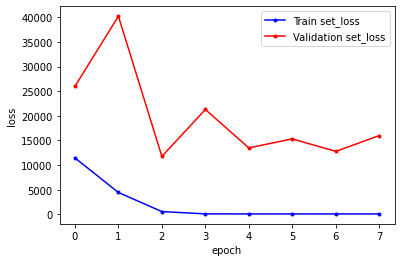

In [ ]:
y_loss = history.history['loss']                                            # 학습 데이터셋 loss
y_valid_loss = history.history['val_loss']                                      # 검증 데이터셋 loss

x_len = np.arange(len(y_loss))                                                  # 0부터 y_loss의 길이만큼 1씩 증가하는 array 생성

plt.plot(x_len, y_loss, marker='.', c='b', label="Train set_loss")              # 학습 데이터셋 loss 표현(파란색)
plt.plot(x_len, y_valid_loss, marker='.', c='r', label="Validation set_loss")   # 검증 데이터셋 loss표현(빨간색)
plt.legend(loc=0)                                                               # lable 위치 지정 (0 = best)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
model = load_model('/gdrive/MyDrive/임시/data/best_model_weights_check_3.h5')

test_df = pd.read_xml("/gdrive/MyDrive/임시/data/Test_sample.xml")
test_df= test_df[1:]
test_transformed = preprocessor_pipe.transform(test_df) 
test = test_transformed.reshape(-1,300,8)  
preds = model.predict(test_a)

# 예측값 출력
print('Predicted A:', preds) # Real label : 125.4